# SPOmiAlign Demo: Puck 29 Alignment

**任务**：将 Slide-seq Puck 29 数据配准到 CCF 参考图。
**参数**：
* 旋转：180度

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../../SPOmiAlign")
from roma import align_and_process_images
from data_preprocessing import rasterize_h5ad_to_image



✅ Successfully imported 'rasterize_h5ad_to_image' from data_process.py


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.9.0+cu128 with CUDA 1208 (you have 2.7.1+cu126)
    Python  3.10.19 (you have 3.12.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


🚀 H5AD 转图像 (180度旋转)...
✅ PNG 已保存：../../output/h5ad_2_img/PUCK29/Gen_img_PUCK29.png（4779×5498，background=black，shape=circle，radius=5）


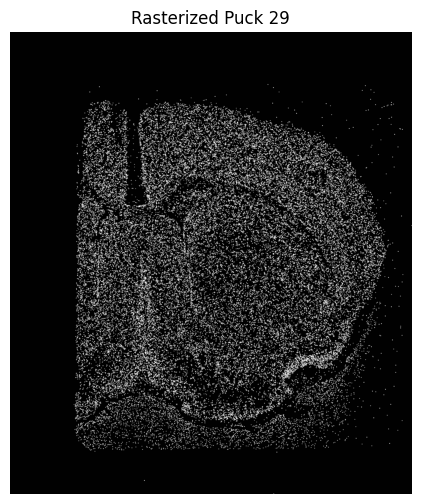

In [2]:
# --- 配置 ---
DATA_DIR = "../../SPOmiAlign_Repro"
SAVE_PATH = os.path.join("../../output", "h5ad_2_img", "PUCK29")
os.makedirs(SAVE_PATH, exist_ok=True)

h5ad_path = os.path.join(DATA_DIR, "data_preprocessing", "Puck_Num_29.h5ad")
target_img_path = os.path.join(DATA_DIR, "output_reference", "CCF_100048576_205.png")
gen_img_path = os.path.join(SAVE_PATH, "Gen_img_PUCK29.png")

print("🚀 H5AD 转图像 (180度旋转)...")
_, origin = rasterize_h5ad_to_image(
    input_h5ad=h5ad_path, output_png=gen_img_path,
    x_obs_col="Raw_Slideseq_X", y_obs_col="Raw_Slideseq_Y",
    intensity_obs_col="nFeature_Spatial", intensity_log_transform=True,
    threshold_percentile=80, background="black", point_shape="circle", radius=5,
    enhance=True, rotate=180, scale=1.0,
)

plt.figure(figsize=(6,6))
plt.imshow(cv2.imread(gen_img_path), cmap='gray')
plt.title("Rasterized Puck 29")
plt.axis('off')
plt.show()

🚀 执行配准...
Using device: cuda:0


2026-01-04 21:29:15.925 | INFO     | romatch.models.model_zoo.roma_models:roma_model:61 - Using coarse resolution (560, 560), and upsample res (864, 1152)


Running RoMa matching...
Estimating affine+bspline transform...
Warping images...
Padding fill color (from 10,10): [1, 1, 1]
Processing H5AD coordinates...
Raw_Slideseq_X Raw_Slideseq_Y
🔄 Applying manual pre-transform: rotate=180.0°, scale=1.0
⚠️ Removing '_index' column from adata.var...
⚠️ Removing '_index' column from adata.raw.var...
✅ Saved transformed H5AD to ../../output/h5ad_2_img/PUCK29/alignment/transformed.h5ad


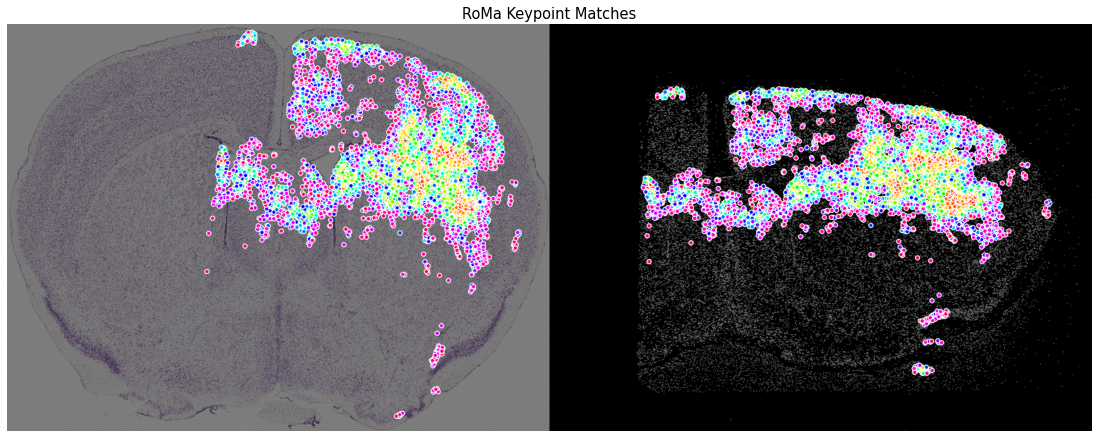

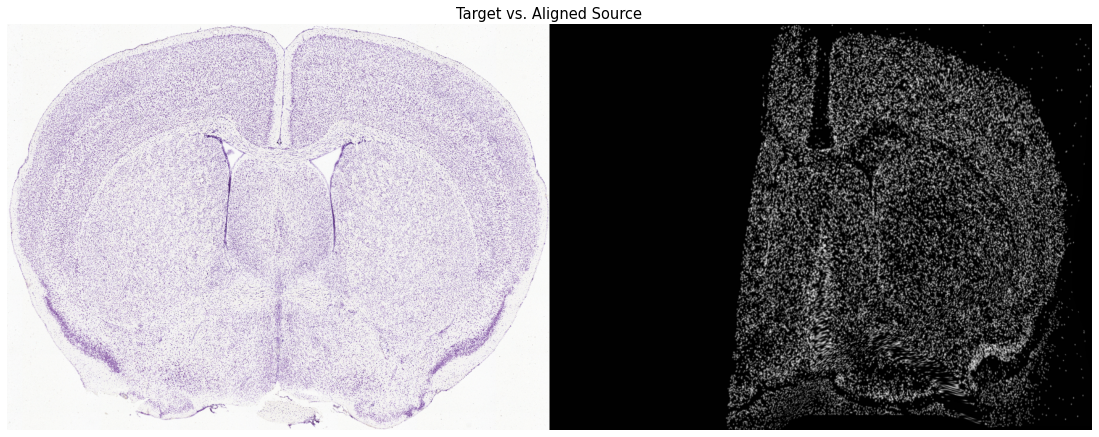

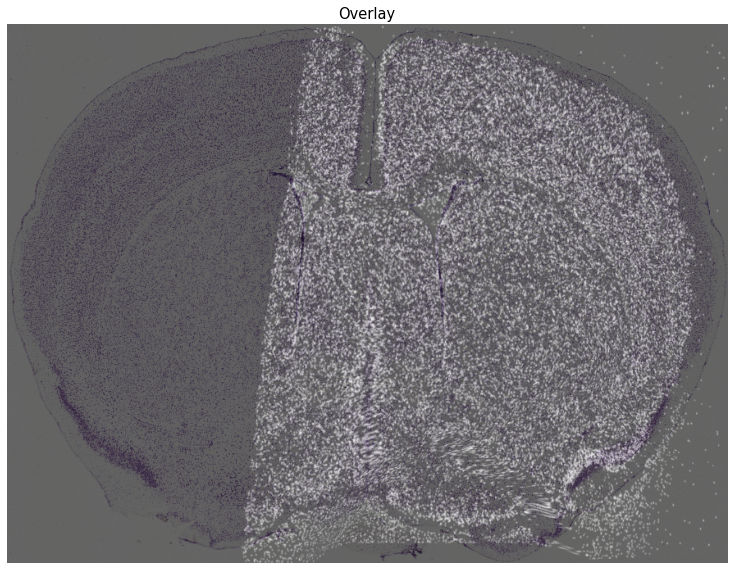

Alignment runtime: 13.6814 seconds
Done. Results saved to ../../output/h5ad_2_img/PUCK29/alignment
✅ PNG 已保存：../../output/h5ad_2_img/PUCK29/alignment/transformed_h5ad.png（915×785，background=black，shape=circle，radius=2）


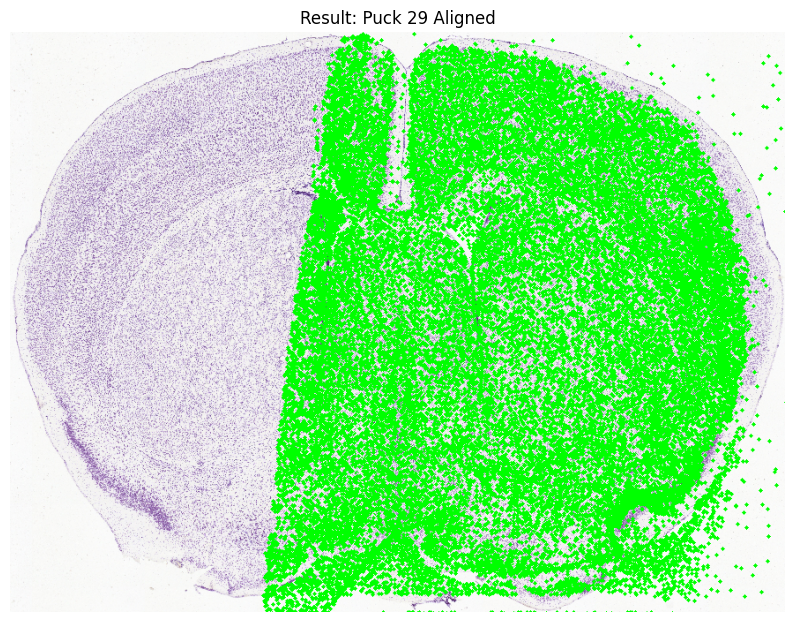

In [3]:
# --- 配准与叠加 ---
print("🚀 执行配准...")
save_align = os.path.join(SAVE_PATH, "alignment")
trans_h5ad = os.path.join(save_align, "transformed.h5ad")
trans_img = os.path.join(save_align, "transformed_h5ad.png")

# 1. 配准
align_and_process_images(
    img1_path=target_img_path, img2_path=gen_img_path, h5ad_path=h5ad_path,
    method='affine+bspline', output_dir=save_align,
    x_obs_col="Raw_Slideseq_X", y_obs_col="Raw_Slideseq_Y",
    rotate=180.0, scale=1.0, origin=origin
)

# 2. 验证图生成
rasterize_h5ad_to_image(
    input_h5ad=trans_h5ad, output_png=trans_img,
    x_obs_col="Raw_Slideseq_X", y_obs_col="Raw_Slideseq_Y",
    intensity_obs_col="nFeature_Spatial", intensity_log_transform=True,
    threshold_percentile=80, background="black", point_shape="circle", radius=2,
    enhance=True, rotate=0.0, scale=1.0,
)

# 3. 叠加显示
t_img = cv2.imread(target_img_path)
s_img = cv2.imread(trans_img, cv2.IMREAD_GRAYSCALE)

if t_img is not None and s_img is not None:
    h, w = s_img.shape
    mask = np.zeros(t_img.shape[:2], dtype=np.uint8)
    mask[:min(mask.shape[0], h), :min(mask.shape[1], w)] = s_img[:min(mask.shape[0], h), :min(mask.shape[1], w)]
    
    overlay = t_img.copy()
    overlay[mask > 50] = [0, 255, 0] # 绿色

    cv2.imwrite(os.path.join(save_align, "final_overlay.png"), overlay)
    
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Result: Puck 29 Aligned")
    plt.axis('off')
    plt.show()